In [1]:
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from modSAR.datasource import ChEMBLApiDataSource, preprocess_activities
from modSAR.cdk_utils import JavaCDKBridge

/opt/conda/lib/python3.6/site-packages/grequests.py:21: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/conda/lib/python3.6/site-packages/urllib3/util/__init__.py)', 'urllib3.contrib.pyopenssl (/opt/conda/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py)']. 
  curious_george.patch_all(thread=False, select=False)


TODO DOCUMENTATION:

- Using ChEMBL API to download inhibitors
- Or prepare your own inhibitors
- Calculate molecular descriptors


# Acquiring Data from ChEMBL

The class `ChEMBLApiDataSource` interacts with the [ChEMBL webresource client API](https://github.com/chembl/chembl_webresource_client) to download bioactivities from ChEMBL. 

We must pass the ID of the target protein and the standard types we are interested in and the class will compile the compounds requested into a pandas DataFrame `bioactivities_df`:

In [2]:
chembl_data_source = ChEMBLApiDataSource(target_id='CHEMBL202', standard_types=['IC50', 'Ki'])
bioactivities_df = chembl_data_source.bioactivities_df

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In total, the API returned 1500+ bioactivities registered as hDHFR ligands [CHEMBL202](https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL202):

In [3]:
chembl_data_source

ChEMBLApiDataSource object
  target_id: CHEMBL202
  bioactivities: 1573
  standard_types: ['Ki' 'IC50' 'Log 1/Ki app' 'IC50/[E]' 'Ratio IC50']

Here is a peak into everything returned from ChEMBL API:

In [4]:
bioactivities_df.head()

activity_comment activity_id assay_chembl_id  ...  uo_units upper_value value
0             None       40879    CHEMBL858267  ...      None        None  7.03
0             None       42137    CHEMBL858267  ...      None        None  7.65
0             None       42149    CHEMBL858267  ...      None        None  6.11
0             None       45682    CHEMBL858267  ...      None        None  6.71
0             None       46931    CHEMBL666808  ...      None        None  7.37

[5 rows x 46 columns]

The distribution of standard activity types in the data set:

In [5]:
bioactivities_df['standard_type'].value_counts()

IC50            1090
Ki               435
Log 1/Ki app      38
IC50/[E]           8
Ratio IC50         2
Name: standard_type, dtype: int64

# Preprocessing

A function `preprocess_activities` exists to filter out invalid/more inaccurate entries for QSAR modelling. In summary, this function:

- Select only valid entries as indicated by the column `data_validity_comment`
- Select only entries where relation is of type equality (e.g.: IC50 = 30nM), as indicated by column `relation`
- Handle duplicated entries
- Remove data marked as outliers


In [3]:
preprocessed_df = preprocess_activities(bioactivities_df)

Because of this preprocessing step, the resulting data set has fewer entries:

In [7]:
preprocessed_df.shape

(800, 51)

Number of duplicated entries that existed in the dataset and were converted to a single entry:

In [8]:
preprocessed_df['duplicated'].sum()

188

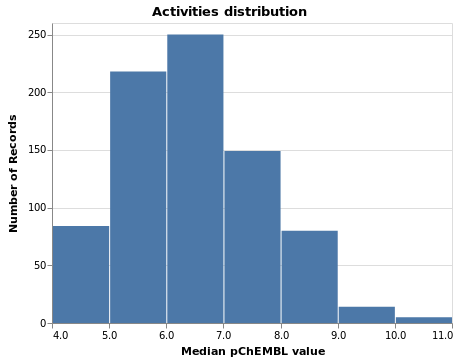

In [9]:
import altair as alt

alt.renderers.enable('notebook')

chart = alt.Chart(preprocessed_df).mark_bar().encode(
    x=alt.X("median_pchembl_value", bin=True, title='Median pChEMBL value'),
    y='count()',
    tooltip=['count()'],
).properties(
    title='Activities distribution'
)

chart

![Activities distribution](fig/notebook01/fig01_activities_distribution.png)

# Molecular Descriptors

After removing invalid and handling duplicated entries, we use Chemistry Development Kit ([CDK v2.2](https://github.com/cdk/cdk)) to calculate molecular descriptors on the resulting dataset.

In order to run CDK in Python, we need to establish a bridge with the Java programming language:

In [4]:
java_cdk_bridge = JavaCDKBridge()
java_cdk_bridge.start_cdk_java_bridge()

b'jovyan     878  0.0  0.0   4504   796 ?        S    20:15   0:00 /bin/sh -c ps aux | grep CDK\njovyan     880  0.0  0.0  12944  1072 ?        S    20:15   0:00 grep CDK\n'
Compiling CDKBridge
Starting CDKBridge


Now, we can instantiate classes and manipulate CDK Java objects from within Python:

In [9]:
gateway = java_cdk_bridge.gateway
cdk = gateway.jvm.org.openscience.cdk

builder = cdk.DefaultChemObjectBuilder.getInstance()
smiles_parser = cdk.smiles.SmilesParser(builder)
builder

JavaObject id=o1

**DESCRIPTORS LIST**

For convenience, we saved a list of all molecular descriptors classes in CDK in the `descriptors_list.csv`. 

In [11]:
descriptors_list = pd.read_csv('/mnt/data/descriptors_list.csv')

def remove_prefix(java_class_name):
    return java_class_name.replace('org.openscience.', '') + '()'

descriptors_list['object_invocation'] = descriptors_list['descriptorClass'].apply(remove_prefix)
descriptors_list

category                        ...                                                          object_invocation
0           hybrid                        ...                            cdk.qsar.descriptors.molecular.WHIMDescriptor()
1           hybrid                        ...                            cdk.qsar.descriptors.molecular.BCUTDescriptor()
2   constitutional                        ...                           cdk.qsar.descriptors.molecular.XLogPDescriptor()
3   constitutional                        ...                          cdk.qsar.descriptors.molecular.WeightDescriptor()
4   constitutional                        ...                          cdk.qsar.descriptors.molecular.RuleOfFiveDescr...
5   constitutional                        ...                          cdk.qsar.descriptors.molecular.RotatableBondsC...
6   constitutional                        ...                          cdk.qsar.descriptors.molecular.MannholdLogPDes...
7   constitutional                        ...                          cdk.qsar.descriptors.molecular.LongestAliphati...
8   constitutional                        ...                          cdk.qsar.descriptors.molecular.LargestPiSystem...
9   constitutional                        ...                          cdk.qsar.descriptors.molecular.LargestChainDes...
10  constitutional                        ...                          cdk.qsar.descriptors.molecular.BondCountDescri...
11  constitutional                        ...                          cdk.qsar.descriptors.molecular.BasicGroupCount...
12  constitutional                        ...                          cdk.qsar.descriptors.molecular.AtomCountDescri...
13  constitutional                        ...                          cdk.qsar.descriptors.molecular.AromaticBondsCo...
14  constitutional                        ...                          cdk.qsar.descriptors.molecular.AromaticAtomsCo...
15  constitutional                        ...                           cdk.qsar.descriptors.molecular.ALOGPDescriptor()
16  constitutional                        ...                          cdk.qsar.descriptors.molecular.AcidicGroupCoun...
17     topological                        ...                          cdk.qsar.descriptors.molecular.SmallRingDescri...
18     topological                        ...                          cdk.qsar.descriptors.molecular.FractionalPSADe...
19     topological                        ...                          cdk.qsar.descriptors.molecular.ZagrebIndexDesc...
20     topological                        ...                          cdk.qsar.descriptors.molecular.WienerNumbersDe...
21     topological                        ...                          cdk.qsar.descriptors.molecular.WeightedPathDes...
22     topological                        ...                          cdk.qsar.descriptors.molecular.VAdjMaDescriptor()
23     topological                        ...                            cdk.qsar.descriptors.molecular.VABCDescriptor()
24     topological                        ...                            cdk.qsar.descriptors.molecular.TPSADescriptor()
25     topological                        ...                          cdk.qsar.descriptors.molecular.PetitjeanShapeI...
26     topological                        ...                          cdk.qsar.descriptors.molecular.PetitjeanNumber...
27     topological                        ...                             cdk.qsar.descriptors.molecular.MDEDescriptor()
28     topological                        ...                          cdk.qsar.descriptors.molecular.KierHallSmartsD...
29     topological                        ...                          cdk.qsar.descriptors.molecular.KappaShapeIndic...
30     topological                        ...                          cdk.qsar.descriptors.molecular.HybridizationRa...
31     topological                        ...                          cdk.qsar.descriptors.molecular.FragmentComplex...
32     topologica

We can calculate and combine 

In [25]:
import py4j

def calculate_all_descriptors(data, descriptors_df):
    mol_container = smiles_parser.parseSmiles(data['canonical_smiles'])
    dict_descriptors = {}
    for i in range(descriptors_df.shape[0]):
        descriptor = eval(descriptors_df.iloc[i]['object_invocation'])
        descriptor.initialise(builder)
        descriptor_names = [desc_name for desc_name in descriptor.getDescriptorNames()]
        try:
            descriptor_values = descriptor.calculate(mol_container).getValue().toString().split(',')
        except Exception as e:
            print(e)
        
        dict_descriptors.update({descriptor_names[j]: descriptor_values[j] 
                                 for j in range(len(descriptor_names))})
    
    result_df = pd.DataFrame(dict_descriptors, index=[data['parent_molecule_chembl_id']])
    return result_df

pd.concat([
    calculate_all_descriptors(preprocessed_df.iloc[1], descriptors_list),
    calculate_all_descriptors(preprocessed_df.iloc[0], descriptors_list)], axis=0)

Wlambda1.unity Wlambda2.unity  ...   GRAV-5 GRAV-6
CHEMBL33697            NaN            NaN  ...      NaN    NaN
CHEMBL7130             NaN            NaN  ...      NaN    NaN

[2 rows x 286 columns]

\#TODO: Errors

In [26]:
preprocessed_df.apply(calculate_all_descriptors, axis=1, descriptors_df=descriptors_list)

An error occurred while calling o8502.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lon

An error occurred while calling o8718.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lon

An error occurred while calling o8934.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lon

An error occurred while calling o9150.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lon

An error occurred while calling o9583.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lon

An error occurred while calling o9799.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lon

An error occurred while calling o10015.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o10231.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o10447.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o10663.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o10879.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/py4j/java_gateway.py", line 1181, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/opt/conda/lib/python3.6/site-packages/gevent/_socket3.py", line 433, in recv_into
    self._wait(self._read_event)
  File "src/gevent/_hub_primitives.py", line 265, in gevent.__hub_primitives.wait_on_socket
  File "src/gevent/_hub_primitives.py", line 266, in gevent.__hub_primitives.wait_on_socket
  File "src/gevent/_hub_primitives.py", line 252, in gevent.__hub_primitives._primitive_wait
  File "src/gevent/_hub_primitives.py", line 46, in gevent.__hub_primitives.WaitOperationsGreenlet.wait
  File "src/gevent/_hub_primitives.py", line 46, in gevent.__hub_primitives.WaitOperationsGreenlet.wait
  File "src/gevent/_hub_primitives.py", line 55, in gevent

An error occurred while calling o18225.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o18441.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/py4j/java_gateway.py", line 1181, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/opt/conda/lib/python3.6/site-packages/gevent/_socket3.py", line 433, in recv_into
    self._wait(self._read_event)
  File "src/gevent/_hub_primitives.py", line 265, in gevent.__hub_primitives.wait_on_socket
  File "src/gevent/_hub_primitives.py", line 266, in gevent.__hub_primitives.wait_on_socket
  File "src/gevent/_hub_primitives.py", line 252, in gevent.__hub_primitives._primitive_wait
  File "src/gevent/_hub_primitives.py", line 46, in gevent.__hub_primitives.WaitOperationsGreenlet.wait
  File "src/gevent/_hub_primitives.py", line 46, in gevent.__hub_primitives.WaitOperationsGreenlet.wait
  File "src/gevent/_hub_primitives.py", line 55, in gevent

An error occurred while calling o26217.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o26433.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o26649.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o26865.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o27081.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o27297.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o27513.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o27729.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o27945.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o28161.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o28377.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o28593.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o28809.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o29025.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o29241.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o29457.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o29673.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o29889.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o30105.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o30321.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o30537.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o30753.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o30969.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o31185.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o31401.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o31617.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o31833.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o32049.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o32265.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o32481.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o32697.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o32913.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o33129.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

An error occurred while calling o33345.calculate.
: java.lang.StackOverflowError
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(LongestAliphaticChainDescriptor.java:159)
	at org.openscience.cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor.getMaxDepth(Lo

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/py4j/java_gateway.py", line 1181, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/opt/conda/lib/python3.6/site-packages/gevent/_socket3.py", line 433, in recv_into
    self._wait(self._read_event)
  File "src/gevent/_hub_primitives.py", line 265, in gevent.__hub_primitives.wait_on_socket
  File "src/gevent/_hub_primitives.py", line 266, in gevent.__hub_primitives.wait_on_socket
  File "src/gevent/_hub_primitives.py", line 252, in gevent.__hub_primitives._primitive_wait
  File "src/gevent/_hub_primitives.py", line 46, in gevent.__hub_primitives.WaitOperationsGreenlet.wait
  File "src/gevent/_hub_primitives.py", line 46, in gevent.__hub_primitives.WaitOperationsGreenlet.wait
  File "src/gevent/_hub_primitives.py", line 55, in gevent

Py4JError: ('An error occurred while calling o2.parseSmiles', 'occurred at index 335')

In [ ]:
py4j.java_gateway.get_field(descriptor, 'CHECK_RING_SYSTEM')

In [ ]:
[f for f in descriptor.getParameters()]

In [ ]:
gateway.jvm.java.lang.Object()

In [ ]:
descriptor.setParameters(['false'])

In [ ]:
descriptor = cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor()
mol_container = smiles_parser.parseSmiles(preprocessed_df.iloc[2]['canonical_smiles'])
descriptor.calculate(mol_container).getValue().toString().split(',')

In [ ]:
m = Chem.MolFromSmiles(preprocessed_df.iloc[3]['canonical_smiles'])
m

In [ ]:
AllChem.CalcKappa1(m)

In [ ]:
result_df.columns.tolist()